### A basic illustration of phases 2 and 3 of comet interceptor

- Phase 2 : Station-keeping in the halo orbit around Sun-Earth L2 
- Phase 3 : Impulsive maneuver to leave the L2 point

In [84]:
# Importing required computing packages
import numpy as np
from scipy.integrate import odeint

# Importing required plotting packages
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#### Free dynamics 

The spacecraft's free dynamics in the restricted three body problem

\begin{equation}
\begin{cases}
\dot{x} = v_x \\[.4em]
\dot{y} = v_y \\[.4em]
\dot{z} = v_z \\[.1em]
\ddot{x}=x + 2 v_y - \cfrac{(1-\mu)(x+\mu)}{r_1^3} - \cfrac{\mu(x+\mu -1 )}{r_2^3} \\[.1em]
\ddot{y}=y - 2 v_x - \cfrac{(1 - \mu)y}{r_1^3} - \cfrac{\mu y}{r_2^3} \\[.1em]
\ddot{z}=- \cfrac{(1 - \mu)z}{r_1^3} - \cfrac{\mu z}{r_2^3}
\end{cases}
\end{equation}

In [85]:
def Free_dynamics(X, t):
    x, y, z, xdot, ydot, zdot = X
    r1 = np.sqrt((x      + mu)**2 + y**2 + z**2)
    r2 = np.sqrt((x - 1. + mu)**2 + y**2 + z**2)
    
    xddot  = x + 2.*ydot - (1.-mu)*(x + mu)/r1**3 - mu*(x -1.+mu)/r2**3

    yddot  = -2.*xdot + y*(1. - (1.-mu)/r1**3 - mu/r2**3)

    zddot  = -z * ((1. - mu)/r1**3 + mu/r2**3)

    return np.array([xdot, ydot, zdot, xddot, yddot, zddot])

#### Forced dynamics 

The spacecraft's forced dynamics (with propulsion system) in the restricted three body problem

\begin{equation}
\begin{cases}
\dot{x} = v_x \\[.4em]
\dot{y} = v_y \\[.4em]
\dot{z} = v_z \\[.1em]
\ddot{x}=x + 2 v_y - \cfrac{(1-\mu)(x+\mu)}{r_1^3} - \cfrac{\mu(x+\mu -1 )}{r_2^3} + \cfrac{T_x}{m}\delta(t-t_D)\\[.1em]
\ddot{y}=y - 2 v_x - \cfrac{(1 - \mu)y}{r_1^3} - \cfrac{\mu y}{r_2^3} + \cfrac{T_y}{m}\delta(t-t_D)\\[.1em]
\ddot{z}=- \cfrac{(1 - \mu)z}{r_1^3} - \cfrac{\mu z}{r_2^3} +\cfrac{T_z}{m}\delta(t-t_D)
\end{cases}
\end{equation}

In [86]:
def Forced_dynamics(Z, t):

    x, y, z, xdot, ydot, zdot = Z[:6]
    ux, uy, uz = Z[6:]
    r1 = np.sqrt((x      + mu)**2 + y**2 + z**2)
    r2 = np.sqrt((x - 1. + mu)**2 + y**2 + z**2)
    
    
    xddot  = x + 2.*ydot - (1.-mu)*(x + mu)/r1**3 - mu*(x -1.+mu)/r2**3 + ux

    yddot  = -2.*xdot + y*(1. - (1.-mu)/r1**3 - mu/r2**3) + uy

    zddot  = -z * ((1. - mu)/r1**3 + mu/r2**3) + uz

    return np.array([xdot, ydot, zdot, xddot, yddot, zddot, 0, 0, 0])

####  Halo orbit construction

Spacecraft orbiting SE2

In [87]:
# Assumed fundamental parameter mu 
mu = 0.04

# The state's initial condition 
X0 = np.array([1.220839, 0, 0.200987, 0, -0.310434, 0])

# Halo orbit's half period
Thalf0  = 1.700458
# Halo orbit's period
T0      = 2.0*Thalf0
# Time interval
N_half  = 200
t_orbit = T0 * np.linspace(0.0, 1.0, 2*N_half+1)

# Propagate the state to construct the orbit
X_orbit = odeint(Free_dynamics, X0, t_orbit)


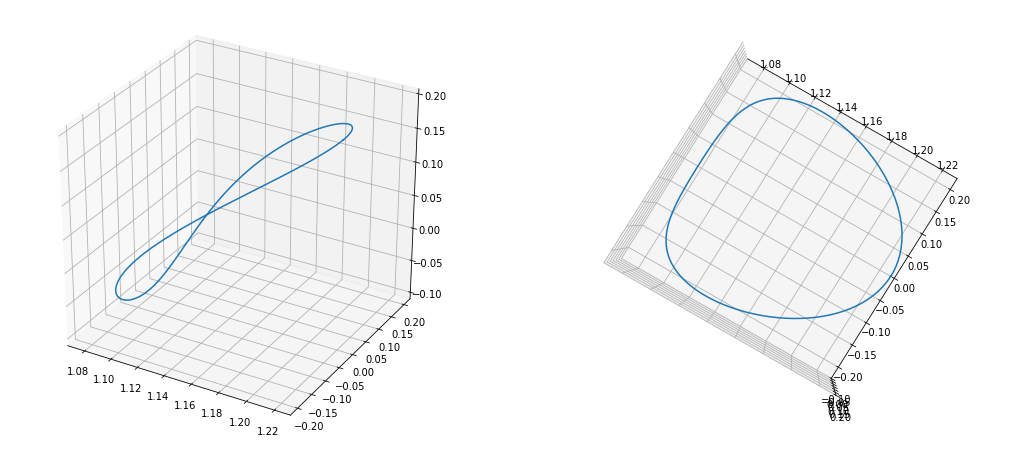

In [88]:
fig = plt.figure(figsize=[18, 8])

# Front view
ax = fig.add_subplot(1, 2, 1, projection='3d')

x_orbit, y_orbit, z_orbit = X_orbit.T[:3]
ax.plot(x_orbit, y_orbit, z_orbit)

# Top view
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax2.plot(x_orbit, y_orbit, z_orbit)

ax2.view_init(90)

In [119]:
#### Impulse control vector ####
# The chemical rocket's thrust (N)
Thrust = np.array([-2, 4, -1])

# The spacecraft's masse (Kg)
mass = 1000

# The control vector (instantaneous acceleration)
u = Thrust/mass 

#### Time of the maneuver and initial state ####
# The impulse is applied at a random instant t_impulse
t_impulse = np.where(t_orbit == np.random.choice(t_orbit, 1))
print(t_impulse)
# The length of the impulse needs to be signifantly short 
len_impulse = 5

# The maneuver's time interval 
t_maneuver = t_orbit[int(t_impulse[0]):int(t_impulse[0])+len_impulse]

# The spacecraft's initial state before the impulse
X0_maneuver = X_orbit[int(t_impulse[0]),:]

# The  Z = [state vector, control vector]
Z0 = np.append(X0_maneuver, u, axis=0)

Z_maneuver = odeint(forced_dynamics, Z0, t_maneuver)

X_maneuver = Z_maneuver[:,:6]

(array([110]),)


In [124]:
# Time interval of the free trajctory after the impulsive maneuver
t_traj = T0 * np.linspace(0.0, 0.8, 2*N_half+1)

# The initial state (Final state after the impulse)
X0_free = Z_maneuver[len(Z_maneuver)-1,:6]

# 
X_free = odeint(Free_dynamics, X0_free, t_traj)

# The state of the phase 3
X_phase3 = np.append(X_maneuver, X_free, axis=0)

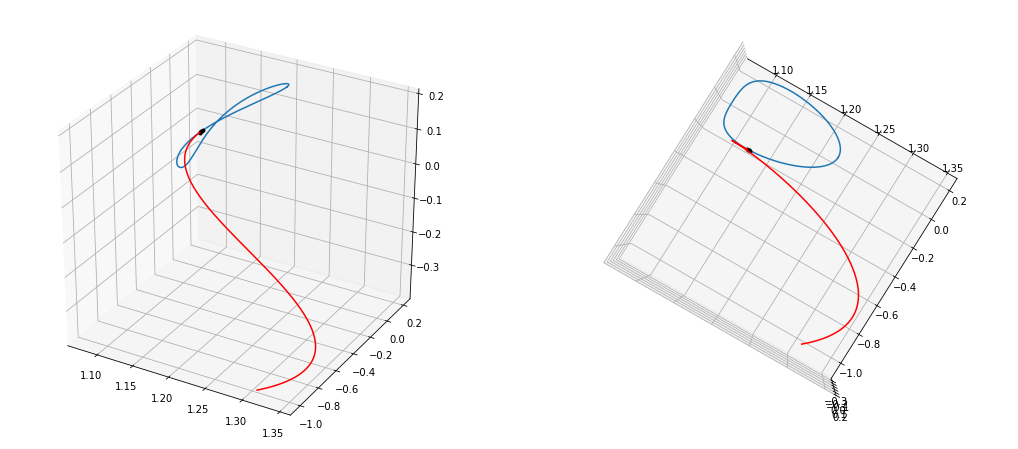

In [125]:
#Plotting the spacecraft's trajectory 
fig = plt.figure(figsize=[18, 8])

# Station-keeping on Halo orbit : Blue

# Impulsive maneuver : Black 

# Liberation trajectory : Red

# Front view
ax = fig.add_subplot(1, 2, 1, projection='3d')

x_orbit, y_orbit, z_orbit = X_orbit.T[:3]
ax.plot(x_orbit, y_orbit, z_orbit)

x_mnv, y_mnv, z_mnv = X_maneuver.T[:3]
ax.plot(x_mnv, y_mnv, z_mnv, 'ok', markersize=3)

x_traj, y_traj, z_traj = X_free.T[:3]
ax.plot(x_traj, y_traj, z_traj, 'r')

# Top view
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax2.plot(x_orbit, y_orbit, z_orbit)

ax2.plot(x_mnv, y_mnv, z_mnv, 'ok', markersize=3)

ax2.plot(x_traj, y_traj, z_traj, 'r')

ax2.view_init(90)

#### Example of construction of a real Sun-Earth L2 halo orbit 

In [113]:
# Real value of mu 
mu = 3.040357143*10**-6

# Initial state, calculated using differential evolution, see paper: Pranav Nath, R V Ramanan, 
# "Precise Halo orbit Design and Optimal Transfer to Halo Orbits from Earth Using Differential Evolution"
X0 = np.array([0.988838391074, 0, 0.000815222286, 0, 0.0089606, 0])

Thalf0 = 1.50
T0     = 2*Thalf0
N_half = 500
t      = T0*np.linspace(0.0, 1.0, 2*N_half+1) 

# Constructing the orbit
X = odeint(Free_dynamics, X0, t, rtol=1E-5, atol=1E-5)

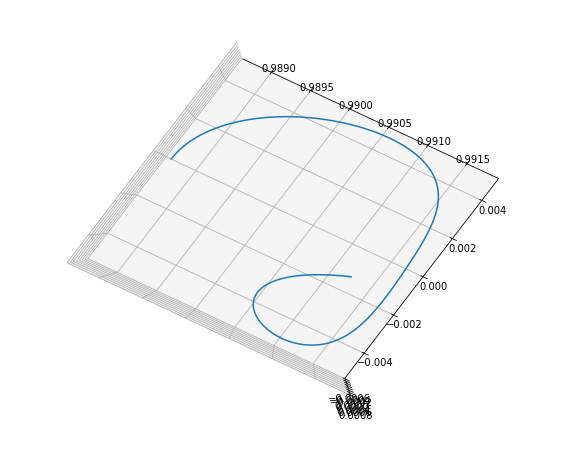

In [83]:
# Plotting the orbit 
# The plot in inaccurate due to perturbations and precision issues of the model and initial condition
fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1, projection='3d')

x,  y,  z  = X.T[:3]
ax.plot(x, y, z)
ax.view_init(90)